In [2]:
using CSV
using Gurobi, JuMP
using DataFrames
using Plots

In [7]:
function process_job_shop_data(filename::String)
    
    # Read the CSV file into a DataFrame
    df = CSV.read(filename, DataFrame)
    
    # Define your sets based on the problem
    II = length(unique(df[!, "Job ID"]))  # Number of jobs
    LL = Dict()  # Number of operations for each job
    GG = Dict()  # Number of groups for each job
    MM = length(unique(df[!, "Machine ID"]))  # Number of machines
    
    # Initialize dictionaries
    MG = Dict()
    nk = Dict()
    Nk = Dict()
    GroupOps = Dict()
    TILK = Dict()
    JO = []
    JobLMachine = Dict()
    GCJ = Dict()
    
    # Populate the dictionaries
    for job in unique(df[!, "Job ID"])
        # Filter rows for the current job
        df_job = df[df[!, "Job ID"] .== job, :]
        
        # Count the number of operations and groups for the current job
        LL[job] = length(unique(df_job[!, "Operation ID"]))
        GG[job] = length(unique(df_job[!, "Group ID"]))
        
        # Group Operations
        for group in unique(df_job[!, "Group ID"])
            GroupOps[(job, group)] = unique(df_job[df_job[!, "Group ID"] .== group, "Operation ID"])
        end
        
        # Machine Groups
        for row in eachrow(df_job)
            group = row["Group ID"]
            machine = get(row, "Machine ID", "")
            if machine != ""
                MG[(job, group)] = union(get(MG, (job, group), []), [parse(Int, replace(machine, r" or .*" => ""))])
            end
        end
        
        # Job Operations
        for op in unique(df_job[!, "Operation ID"])
            JO = union(JO, [(job, op)])
            
            # Time, Machine Operations, and Job Operation Machine
            df_op = df_job[df_job[!, "Operation ID"] .== op, :]
            for row in eachrow(df_op)
                machine = get(row, "Machine ID", "")
                if machine != ""
                    machines = parse.(Int, split(machine, " or "))
                    time = get(row, "Time (s)", "")
                    times = parse.(Int, split(time, " or "))
                    for m in machines
                        TILK[(job, op, m)] = times[1]  # Assuming the first time is the correct one
                        nk[m] = get(nk, m, 0) + 1
                        Nk[m] = union(get(Nk, m, []), [(job, op)])
                        JobLMachine[(job, op)] = union(get(JobLMachine, (job, op), []), [m])
                    end
                end
            end
        end
        
        # Group count for each job
        GCJ[job] = GG[job]
    end
    
    # # Show the variables
    # println("II: ", II)
    # println("LL: ", LL)
    # println("GG: ", GG)
    # println("MM: ", MM)
    # println("MG: ", MG)
    # println("nk: ", nk)
    # println("Nk: ", Nk)
    # println("GroupOps: ", GroupOps)
    # println("TILK: ", TILK)
    # println("JO: ", JO)
    # println("JobLMachine: ", JobLMachine)
    # println("GCJ: ", GCJ)
    return II, LL, GG, MM, MG, nk, Nk, GroupOps, TILK, JO, JobLMachine, GCJ
    
end;

In [26]:
function build_optimization_model(filename::String, M=2000, time_limit=10.0)
    II, LL, GG, MM, MG, nk, Nk, GroupOps, TILK, JO, JobLMachine, GCJ = process_job_shop_data(filename)
    
    # Initialize the model with the Gurobi solver
    model = Model(Gurobi.Optimizer)
    validx = [ (i, l, j, k) for (i, l) in JO for k in JobLMachine[(i, l)] for j in 1:nk[k] ]
    @variable(model, x[validx], Bin)
    @variable(model, h[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
    @variable(model, s[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
    @variable(model, s0[ k in 1:MM ] >= 0, Int)
    @variable(model, TX[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
    valid_deltas = []
    for (group, machines) in MG  # now group is (i, g) pair, machines are idx of M that (i, g) might use
        for a in 1:length(machines)
            for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
                for ll in GroupOps[group], lll in GroupOps[group]
                    if ll != lll
                        for jj in 1:nk[machines[a]], jjj in 1:nk[machines[b]]
                            # group[1] & group[2] are i & g, respectively
                            push!( valid_deltas, (group[1], group[2], machines[a], machines[b], ll, lll, jj, jjj) )
                        end
                    end
                end
            end
        end
    end
    @variable(model, delta[ valid_deltas ] >= 0, Bin);
    @variable(model, h_star >= 0, Int)
    
    # Objective: Minimize the maximum completion time
    @objective(model, Min, h_star);
    
    # Constraint Set 1: Each job-operation pair is processed a specific number of times
    for (i, l) in JO
        if length(JobLMachine[(i, l)]) >= 2
            k1 = JobLMachine[(i, l)][1]
            k2 = JobLMachine[(i, l)][2]
            @constraint(model, sum(x[(i, l, j, k1)] for j in 1:nk[k1]) + sum(x[(i, l, j, k2)] for j in 1:nk[k2]) == 1)
        else
            k = JobLMachine[(i, l)][1]
            @constraint(model, sum(x[(i, l, j, k)] for j in 1:nk[k]) == 1)
        end
    end
    
    # Constraint Set 2: At most one operation at each order position on each machine
    for k in 1:MM 
        for j in 1:nk[k]
            @constraint(model, sum(x[(i, l, j, k)] for (i, l) in Nk[k]) <= 1)
        end
    end
    
    # Constraint Set 3: Define the processing time for each order position on each machine
    for k in 1:MM
        for j in 1:nk[k]
            @constraint(model, TX[(j, k)] == sum( get(TILK, (i, l, k), 0) * x[(i, l, j, k)] for (i, l) in Nk[k] ))
        end
    end
    for k in 1:MM
        @constraint(model, h[(1, k)] == s0[k])
    end
    for k in 1:MM
        for j in 2:nk[k]
            @constraint(model, h[(j, k)] == sum( TX[(q, k)] for q in 1:j-1 ) + sum( s[(q, k)] for q in 1:j-1 ) + s0[k])
        end
    end
    
    # Constraint Set 4: Precedence constraints
    M = 20000
    for i in 1:II
        for g1 in 2:GCJ[i]
            g = g1 - 1
            # g and g1 are group id of job i: g & g+1
            for ll in GroupOps[(i, g)], lll in GroupOps[(i, g1)]
                for a in JobLMachine[(i, ll)], b in JobLMachine[(i, lll)]
                    for jj in 1:nk[a], jjj in 1:nk[b]
                        @constraint(
                            model,
                            h[(jj, a)] + get(TILK, (i, ll, a), 0) * x[(i, ll, jj, a)] <= h[(jjj, b)] + M * (1 - x[(i, ll, jj, a)]) + M * (1 - x[(i, lll, jjj, b)])
                        )
                    end
                end
            end
        end
    end
    
    # # Constraint Set 5: No overlap within the same machine group
    # for (group, machines) in MG  # now group is (i, g) pair, machines are idx of machines that (i, g) might use
    #     for a in 1:length(machines)
    #         for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
    #             for ll in GroupOps[group], lll in GroupOps[group]
    #                 if ll != lll
    #                     i = group[1]
    #                     ma = machines[a]
    #                     mb = machines[b]
    #                     for jj in 1:nk[ma], jjj in 1:nk[mb]
    #                         if ((i, ll, jj, ma) ∉ validx) || ((i, lll, jjj, mb) ∉ validx) 
    #                             continue
    #                         end
    #                         @constraint(
    #                             model, 
    #                             h[(jj, ma)] + get(TILK, (i, ll, ma), 0) * x[(i, ll, jj, ma)] 
    #                             <= h[(jjj, mb)] + M * (1 - x[(i, ll, jj, ma)] ) + M * (1 - x[(i, lll, jjj, mb)]) 
    #                             + M * delta[(i, group[2], ma, mb, ll, lll, jj, jjj)]
    #                         )
    #                         @constraint(
    #                             model, 
    #                             h[(jjj, mb)] + get(TILK, (i, lll, mb), 0) * x[(i, lll, jjj, mb)] 
    #                             <= h[(jj, ma)] + M * (1 - x[(i, ll, jj, ma)] ) + M * (1 - x[(i, lll, jjj, mb)]) 
    #                             + M * (1 - delta[(i, group[2], ma, mb, ll, lll, jj, jjj)])
    #                         )
    #                     end
    #                 end
    #             end
    #         end
    #     end
    # end
    
    # Constraint Set 6: order pos, can only assign order j+1 when j is assigned
    for k in 1:MM 
        for j in 2:nk[k]
            jprev = j - 1
            @constraint(model, sum(x[(i, l, jprev, k)] for (i, l) in Nk[k]) >= sum(x[(i, l, j, k)] for (i, l) in Nk[k]))
        end
    end
    
    # Constraint Set 7: h_star is greater than or equal to the end time of the last operation on each machine
    for k in 1:MM
        @constraint(model, h_star >= h[(nk[k], k)] + TX[(nk[k], k)])
    end
    
    set_time_limit_sec(model, time_limit)
    optimize!(model)

    x_result = Dict()
    for idx in [ (i, l, j, k) for (i, l) in JO for k in JobLMachine[(i, l)] for j in 1:nk[k] ]
        x_result[idx] = value.(x[idx])
    end
    h_result = Dict()
    for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
        h_result[idx] = value.(h[idx])
    end
    s_result = Dict()
    for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
        s_result[idx] = value.(s[idx])
    end
    s0_result = Dict()
    for idx in 1:MM
        s0_result[idx] = value.(s0[idx])
    end
    TX_result = Dict()
    for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
        TX_result[idx] = value.(TX[idx])
    end

    return model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result
end;

In [27]:
function plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
    end_times = Dict()
    for (j, k) in keys(TX_result)
        end_times[(j, k)] = h_result[(j, k)] + TX_result[(j, k)]
    end
    
    gantt_chart = plot(title="Job Schedule Gantt Chart by Machine", legend=:outertopright)

    # Generate a color for each job
    job_colors = distinguishable_colors(II)

    # Dictionary to keep track of which jobs have been plotted (to avoid duplicate legend entries)
    plotted_jobs = Dict()
    
    # Plot each task
    for k in 1:MM
        machine_schedule = []
        # Gather the tasks for this machine
        for i in 1:II
            for l in 1:LL[i]
                for j in 1:nk[k]
                    if get(x_result, (i, l, j, k), 0) > 0.1
                        push!(machine_schedule, (h_result[(j, k)], h_result[(j, k)] + TX_result[(j, k)], i))
                        break
                    end
                end
            end
        end
        for (start, finish, job_id) in machine_schedule
            color = job_colors[job_id]
            label = haskey(plotted_jobs, job_id) ? "" : "Job $job_id"  # Only label the first task of each job
            plotted_jobs[job_id] = true
            # plot!([start, finish], [k, k], bar=(150, color), label=label)
            shape = Shape([start, start, finish, finish], 
                      [k - 0.4, k + 0.4, k + 0.4, k - 0.4])
            plot!(shape, color=color, label=label)
        end
    end

    xlabel!("Time")
    ylabel!("Machine")
    return gantt_chart
end;

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 12
Set parameter TimeLimit to value 12
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1557 rows, 402 columns and 6617 nonzeros
Model fingerprint: 0xd772a2c5
Variable types: 0 continuous, 402 integer (315 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 111 rows and 177 columns
Presolve time: 0.01s
Presolved: 1446 rows, 225 columns, 6179 nonzeros
Variable types: 0 continuous, 225 integer (172 binary)

Root relaxation: objective 1.800000e+02, 162 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

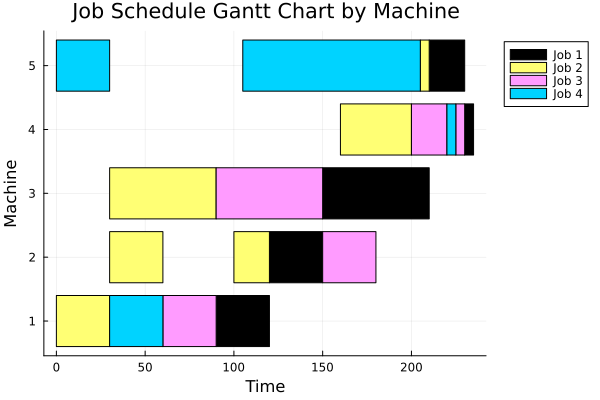

In [34]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 4.csv", 2000, 12) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 15
Set parameter TimeLimit to value 15
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3022 rows, 646 columns and 12853 nonzeros
Model fingerprint: 0x4c72cc83
Variable types: 0 continuous, 646 integer (538 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 120 rows and 291 columns
Presolve time: 0.01s
Presolved: 2902 rows, 355 columns, 12517 nonzeros
Variable types: 0 continuous, 355 integer (277 binary)

Root relaxation: objective 2.400000e+02, 174 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

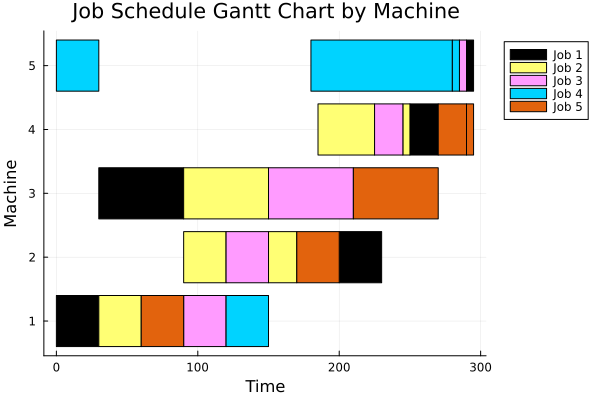

In [35]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 5.csv", 2000, 15) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 18
Set parameter TimeLimit to value 18
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5366 rows, 1038 columns and 22763 nonzeros
Model fingerprint: 0xa751c450
Variable types: 0 continuous, 1038 integer (906 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 183 rows and 531 columns
Presolve time: 0.02s
Presolved: 5183 rows, 507 columns, 22232 nonzeros
Variable types: 0 continuous, 507 integer (411 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 3.000000e+02, 304 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node  

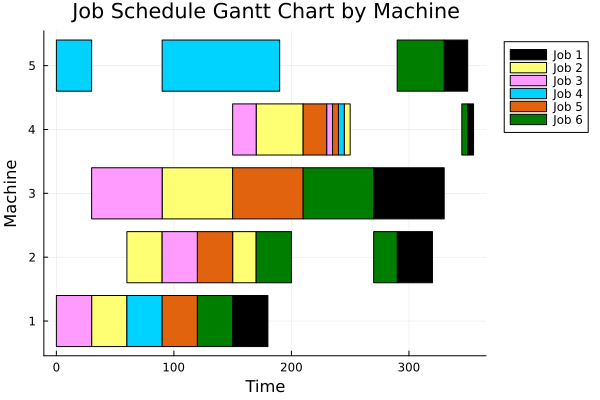

In [36]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 6.csv", 2000, 18) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 21
Set parameter TimeLimit to value 21
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8514 rows, 1482 columns and 35973 nonzeros
Model fingerprint: 0x34b68c08
Variable types: 0 continuous, 1482 integer (1329 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 240 rows and 813 columns
Presolve time: 0.02s
Presolved: 8274 rows, 669 columns, 35200 nonzeros
Variable types: 0 continuous, 669 integer (556 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 3.600000e+02, 388 iterations, 0.02 seconds (0.04 work units)

    Nodes    |    Current Node 

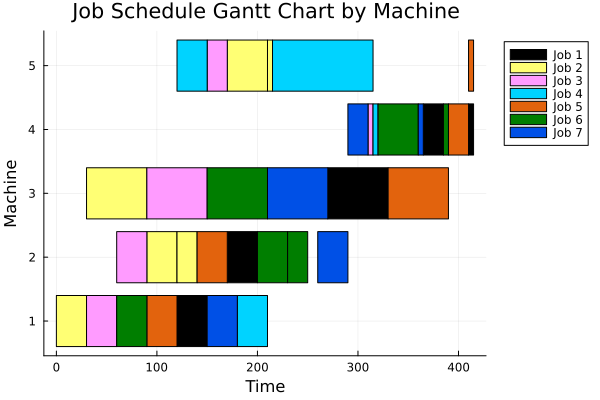

In [37]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 7.csv", 2000, 21) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 24
Set parameter TimeLimit to value 24
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11688 rows, 2004 columns and 49287 nonzeros
Model fingerprint: 0x86533902
Variable types: 0 continuous, 2004 integer (1836 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 307 rows and 1179 columns
Presolve time: 0.04s
Presolved: 11381 rows, 825 columns, 48265 nonzeros
Variable types: 0 continuous, 825 integer (698 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 3.600000e+02, 435 iterations, 0.03 seconds (0.06 work units)

    Nodes    |    Current No

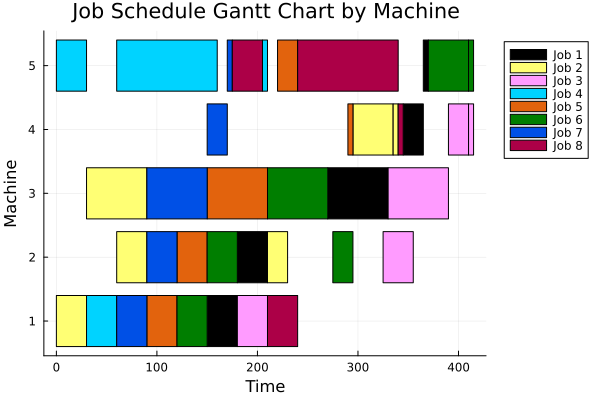

In [38]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 8.csv", 2000, 24) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 27
Set parameter TimeLimit to value 27
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16785 rows, 2658 columns and 70501 nonzeros
Model fingerprint: 0x4309ee45
Variable types: 0 continuous, 2658 integer (2469 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 379 rows and 1629 columns
Presolve time: 0.06s
Presolved: 16406 rows, 1029 columns, 69196 nonzeros
Variable types: 0 continuous, 1029 integer (883 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 4.200000e+02, 592 iterations, 0.05 seconds (0.11 work units)

    Nodes    |    Current 

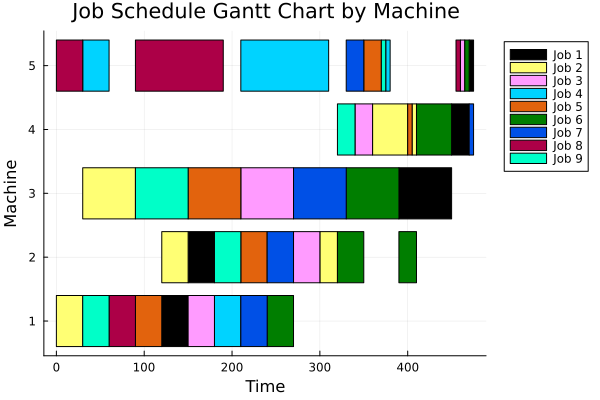

In [39]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 9.csv", 2000, 27) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 23562 rows, 3594 columns and 98631 nonzeros
Model fingerprint: 0x301bf110
Variable types: 0 continuous, 3594 integer (3381 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 473 rows and 2317 columns
Presolve time: 0.07s
Presolved: 23089 rows, 1277 columns, 96962 nonzeros
Variable types: 0 continuous, 1277 integer (1111 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 4.800000e+02, 741 iterations, 0.07 seconds (0.17 work units)

    Nodes    |    Current

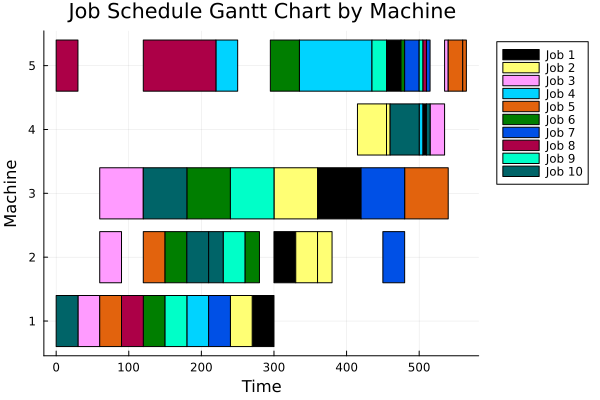

In [40]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 10.csv", 2000, 30) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 33
Set parameter TimeLimit to value 33
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31539 rows, 4556 columns and 131607 nonzeros
Model fingerprint: 0xe1fc164c
Variable types: 0 continuous, 4556 integer (4322 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 563 rows and 3031 columns
Presolve time: 0.09s
Presolved: 30976 rows, 1525 columns, 129541 nonzeros
Variable types: 0 continuous, 1525 integer (1342 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 5.400000e+02, 876 iterations, 0.11 seconds (0.26 work units)

    Nodes    |    Curre

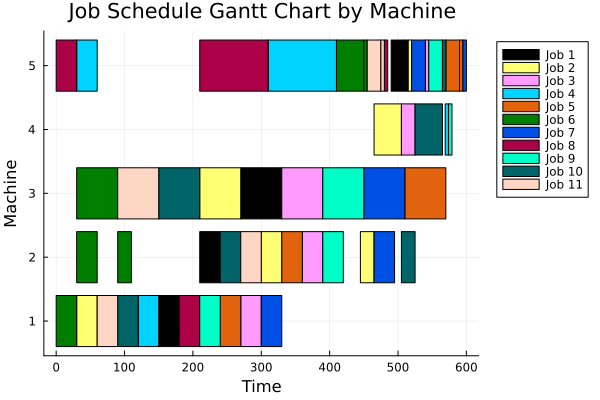

In [41]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 11.csv", 2000, 33) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 36
Set parameter TimeLimit to value 36
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 38967 rows, 5676 columns and 162321 nonzeros
Model fingerprint: 0x1dc7143f
Variable types: 0 continuous, 5676 integer (5427 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 666 rows and 3894 columns
Presolve time: 0.12s
Presolved: 38301 rows, 1782 columns, 158579 nonzeros
Variable types: 0 continuous, 1782 integer (1585 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 5.400000e+02, 839 iterations, 0.12 seconds (0.30 work units)

    Nodes    |    Curre

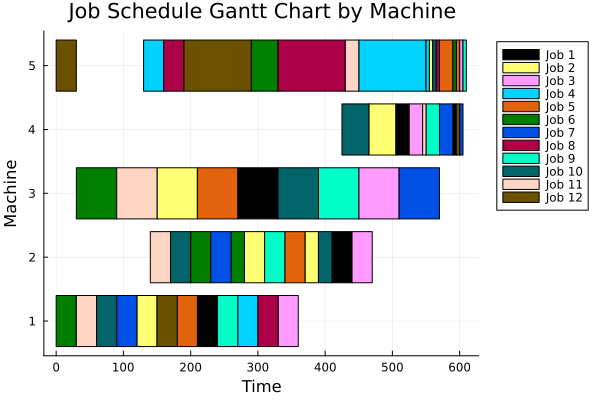

In [42]:
model, nk, MM, II, LL, x_result, h_result, s_result, s0_result, TX_result = build_optimization_model("level4/JSSPlvl4 - 12.csv", 2000, 36) # 3*jobs
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II, LL)
display(gantt_chart_with_job_legends)